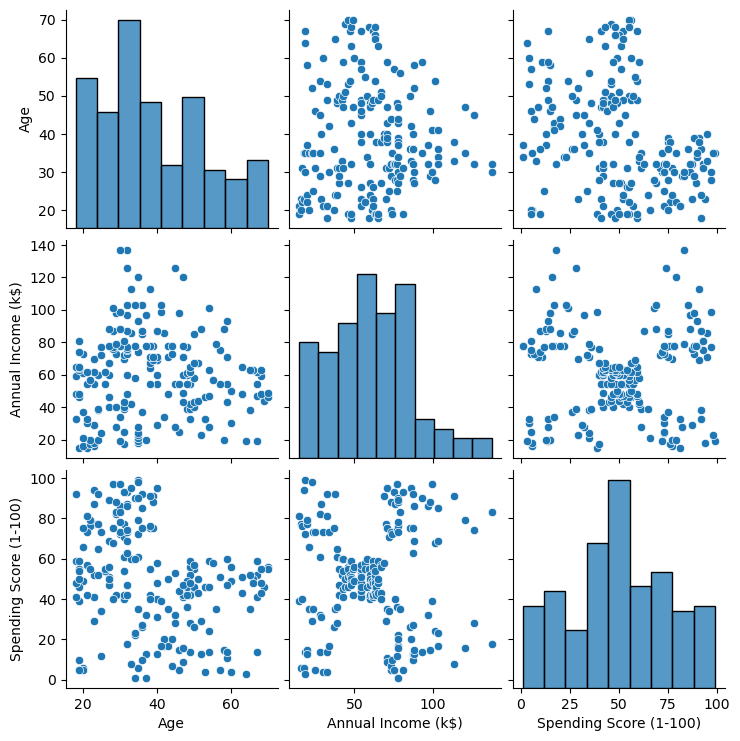

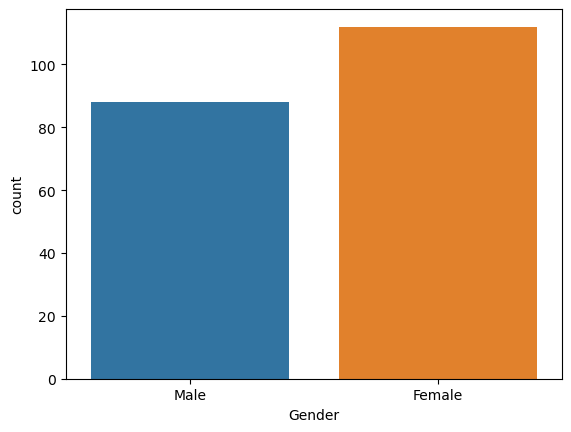

In [3]:
# Customer Analytics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load the dataset
file_path = "/Mall_Customers.csv"
df = pd.read_csv(file_path)
df.head()

# Show distributions and relationships of numerical variables
sns.pairplot(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
plt.show()

# Show gender distribution
sns.countplot(x='Gender', data=df)
plt.show()

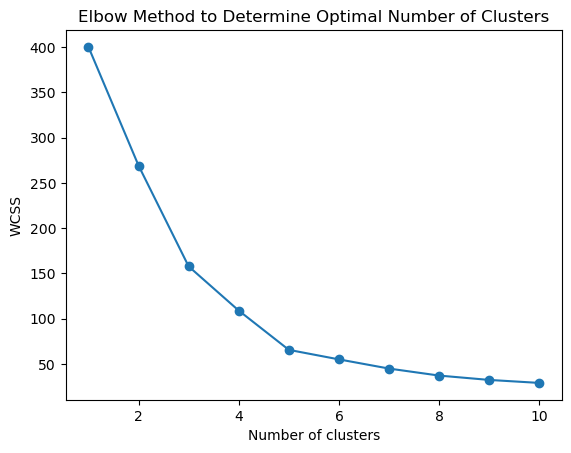

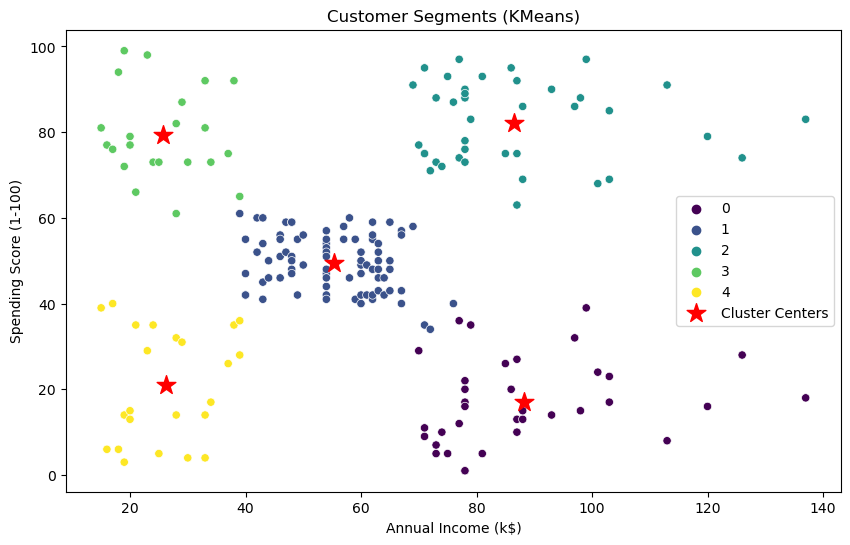

                      Age  Annual Income (k$)  Spending Score (1-100)
KMeans_Cluster                                                       
0               41.114286           88.200000               17.114286
1               42.716049           55.296296               49.518519
2               32.692308           86.538462               82.128205
3               25.272727           25.727273               79.363636
4               45.217391           26.304348               20.913043


In [5]:
# Select variables for clustering
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the data

# KMeans Clustering

# Determine the number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Initialize K-means model with a chosen number of clusters (5 in this case, can be changed)
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
kmeans.fit(X_scaled)
df['KMeans_Cluster'] = kmeans.labels_  # Add cluster labels to the dataset

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='KMeans_Cluster', data=df, palette='viridis')
plt.scatter(scaler.inverse_transform(kmeans.cluster_centers_)[:, 0], scaler.inverse_transform(kmeans.cluster_centers_)[:, 1], 
            s=200, c='red', marker='*', label='Cluster Centers')
plt.title("Customer Segments (KMeans)")
plt.legend()
plt.show()

print(df.groupby('KMeans_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean())  # Show the mean values of clusters


Number of outliers: 51
                      Age  Annual Income (k$)  Spending Score (1-100)
DBSCAN_Cluster                                                       
-1              37.490196           58.333333               44.470588
 0              25.181818           23.090909               74.636364
 1              42.804598           55.413793               48.816092
 2              32.931034           79.241379               83.620690
 3              41.000000           80.181818               12.681818


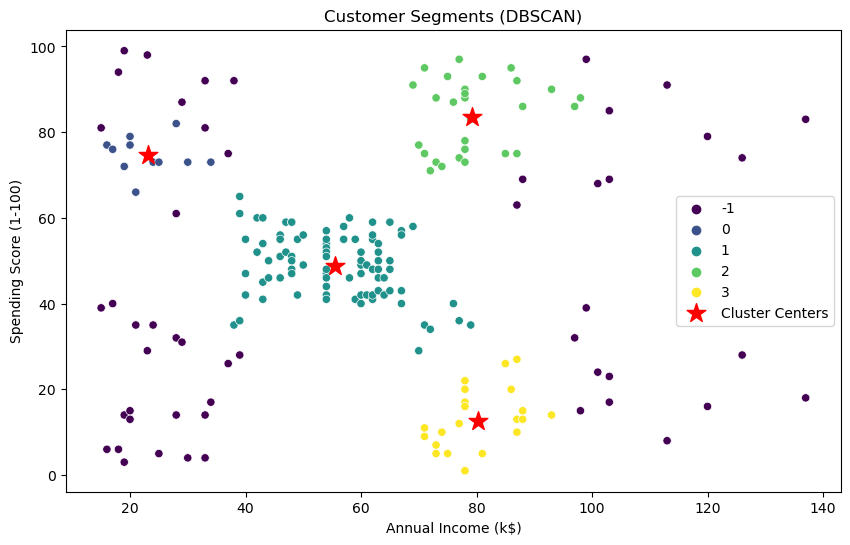

Means of Filtered Clusters:
 | DBSCAN_Cluster   | Age     | Annual Income (k$)   | Spending Score (1-100)   |
|:-----------------|:--------|:---------------------|:-------------------------|
| 0                | 25.1818 | 23.0909              | 74.6364                  |
| 1                | 42.8046 | 55.4138              | 48.8161                  |
| 2                | 32.931  | 79.2414              | 83.6207                  |
| 3                | 41      | 80.1818              | 12.6818                  |


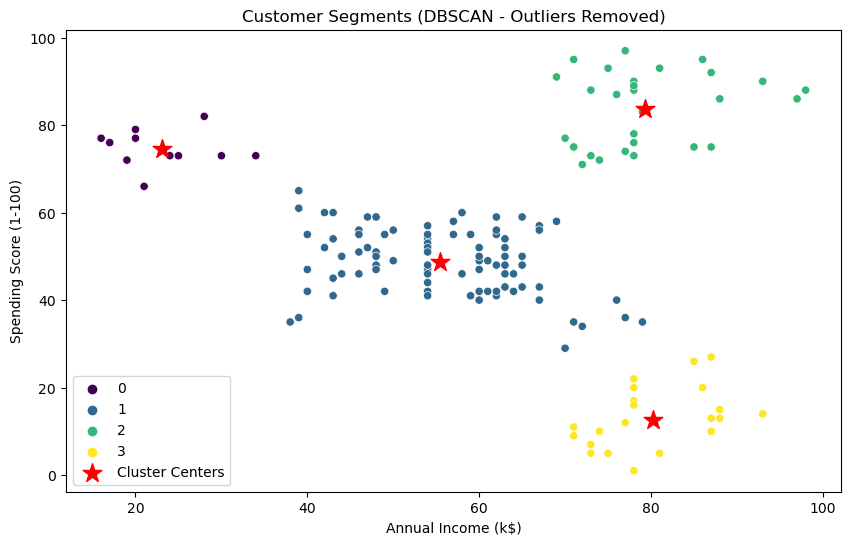

In [6]:
# DBSCAN Clustering

# Apply DBSCAN Algorithm
dbscan = DBSCAN(eps=0.4, min_samples=10)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# Identify outliers
outliers = df[df['DBSCAN_Cluster'] == -1]

# Calculate cluster centers (DBSCAN does not have cluster centers, so we'll use representative points)
cluster_centers = df[df['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()

# Print the number of outliers
print(f"\nNumber of outliers: {len(outliers)}")

# Calculate the means of clusters
print(df.groupby('DBSCAN_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean())

# Visualize DBSCAN Clusters using Matplotlib
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='DBSCAN_Cluster', data=df, palette='viridis', legend='full')
plt.scatter(cluster_centers['Annual Income (k$)'], cluster_centers['Spending Score (1-100)'], 
            s=200, c='red', marker='*', label='Cluster Centers')
plt.title('Customer Segments (DBSCAN)')
plt.legend()
plt.show()

# Filter out the observations belonging to the '-1' cluster
filtered_df = df[df['DBSCAN_Cluster'] != -1].copy()

# Calculate the means of clusters in the filtered dataframe
cluster_means = filtered_df.groupby('DBSCAN_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
print("Means of Filtered Clusters:\n", cluster_means.to_markdown(numalign="left", stralign="left"))

# Calculate cluster centers
cluster_centers = filtered_df.groupby('DBSCAN_Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()

# Visualize filtered DBSCAN clusters using Matplotlib
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='DBSCAN_Cluster', data=filtered_df, palette='viridis', legend='full')
plt.scatter(cluster_centers['Annual Income (k$)'], cluster_centers['Spending Score (1-100)'], 
            s=200, c='red', marker='*', label='Cluster Centers')
plt.title('Customer Segments (DBSCAN - Outliers Removed)')
plt.legend()
plt.show()

In [7]:
# Calculate silhouette scores for both KMeans and DBSCAN (with outliers removed)
kmeans_silhouette = silhouette_score(X_scaled, kmeans.labels_)
dbscan_silhouette = silhouette_score(X_scaled[filtered_df.index], filtered_df['DBSCAN_Cluster'])

print(f"Silhouette Score for KMeans: {kmeans_silhouette}")
print(f"Silhouette Score for DBSCAN (outliers removed): {dbscan_silhouette}")

Silhouette Score for KMeans: 0.5546571631111091
Silhouette Score for DBSCAN (outliers removed): 0.5971952486543135


In [10]:
# Calculate maximum values for each cluster
print("\nMaximum values for each DBSCAN cluster:")
cluster_centers = filtered_df.groupby('DBSCAN_Cluster')[['Annual Income (k$)', 'Spending Score (1-100)', "Age"]].max()
print(cluster_centers)

# Create age groups
print("\nDataframe with age groups:")
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 18, 35, 55, 100], labels=['0-18', '19-35', '36-55', '56+'])
print(df)

# Calculate spending ratio
print("\nDataframe with spending ratio:")
df['Spending_Ratio'] = df['Spending Score (1-100)'] / df['Annual Income (k$)']
print(df)

# Identify the indices of rows where the cluster value is -1
index_to_drop = df[df['DBSCAN_Cluster'] == -1].index

# Drop these rows using the indices
df.drop(index_to_drop, inplace=True)

print("\nDataframe after dropping outliers:")
print(df)


Maximum values for each DBSCAN cluster:
                Annual Income (k$)  Spending Score (1-100)  Age
DBSCAN_Cluster                                                 
0                               34                      82   31
1                               79                      65   70
2                               98                      97   40
3                               93                      27   59

Dataframe with age groups:
     CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
3             4  Female   23                  16                      77   
5             6  Female   22                  17                      76   
9            10  Female   30                  19                      72   
13           14  Female   24                  20                      77   
15           16    Male   22                  20                      79   
..          ...     ...  ...                 ...                     ...   
176         177